In [ ]:
!pip install seaborn

from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, isnan, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, NaiveBayes, DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns

In [ ]:
# Membuat Spark Session
spark = SparkSession.builder.appName("Cancer Data Analysis").getOrCreate()

In [ ]:
# Membaca dataset
df = spark.read.csv("/content/breast-cancer-wisconsin-data_data.csv", header=True, inferSchema=True)

In [ ]:
# Menampilkan 20 baris pertama
df.show()

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+----+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|_c32|
+--------+---------+-----------+------

In [ ]:
# Menghapus kolom yang tidak diperlukan
df = df.drop("_c32")

In [ ]:
# Mengubah nama kolom
df = df.withColumnRenamed("id", "id_pasien")\
       .withColumnRenamed("diagnosis", "diagnosis_kanker")

In [ ]:
# Menampilkan tipe data setiap kolom
df.printSchema()

root
 |-- id_pasien: integer (nullable = true)
 |-- diagnosis_kanker: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = t

In [ ]:
jumlah_null = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+----------------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|id_pasien|diagnosis_kanker|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+----------------+----

In [ ]:
# Mengubah diagnosis_kanker menjadi numerik (1 untuk malignant, 0 untuk benign)
df = df.withColumn("diagnosis_kanker", when(col("diagnosis_kanker") == "M", 1).otherwise(0))

In [ ]:
df.show(5)

+---------+----------------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|id_pasien|diagnosis_kanker|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+----------------+----

In [ ]:
# summery
statistik_ringkasan = df.describe().show()

+-------+--------------------+-------------------+------------------+-----------------+-----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+----------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+
|summary|           id_pasien|   diagnosis_kanker|       radius_mean|     texture_mean|   perimeter_mean|        area_mean|     smoothness_mean|   compactness_mean|     concavity_mean| concave points_mean|       symmetry_mean|fractal_dimension_mean|         radius_se|        texture_se|      perimeter_se|          area_se|       smoothness_se|   

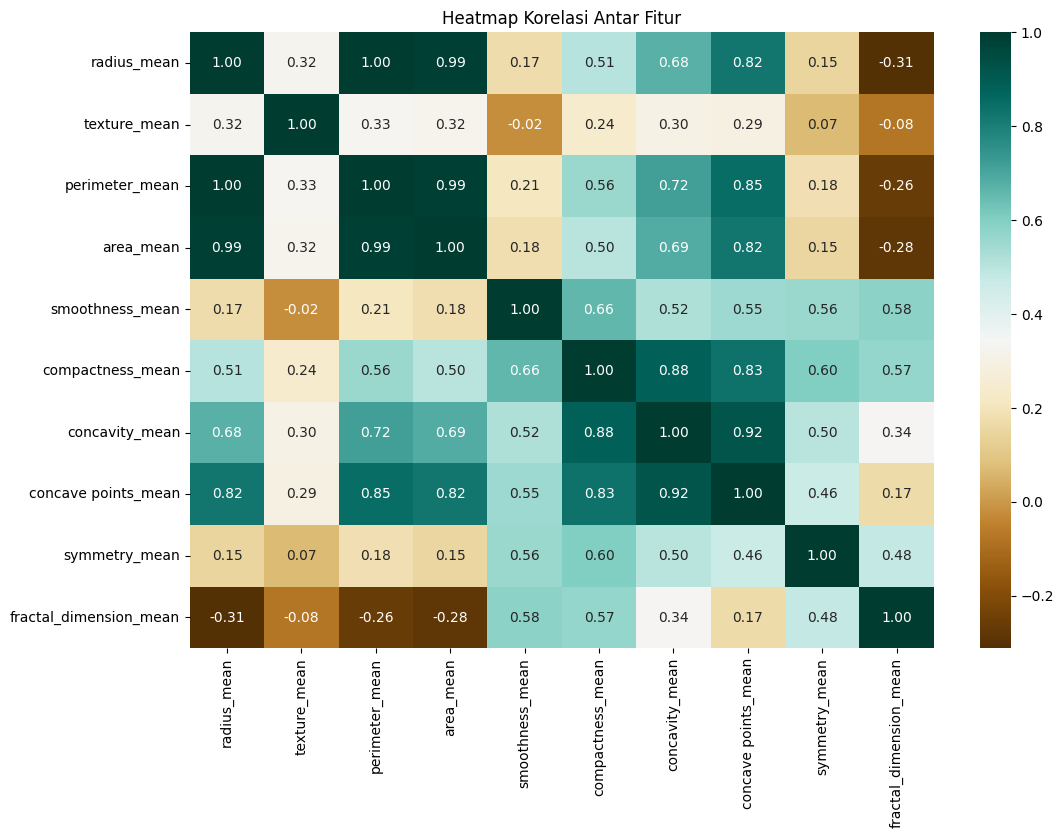

Matriks Korelasi:
                        radius_mean  texture_mean  perimeter_mean  area_mean  \
radius_mean                1.000000      0.323782        0.997855   0.987357   
texture_mean               0.323782      1.000000        0.329533   0.321086   
perimeter_mean             0.997855      0.329533        1.000000   0.986507   
area_mean                  0.987357      0.321086        0.986507   1.000000   
smoothness_mean            0.170581     -0.023389        0.207278   0.177028   
compactness_mean           0.506124      0.236702        0.556936   0.498502   
concavity_mean             0.676764      0.302418        0.716136   0.685983   
concave points_mean        0.822529      0.293464        0.850977   0.823269   
symmetry_mean              0.147741      0.071401        0.183027   0.151293   
fractal_dimension_mean    -0.311631     -0.076437       -0.261477  -0.283110   

                        smoothness_mean  compactness_mean  concavity_mean  \
radius_mean             

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Pilih kolom numerik dari DataFrame PySpark
numeric_columns = ["radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean"]

# Menggabungkan kolom numerik menjadi satu kolom vektor fitur
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
df_vector = assembler.transform(df)

# Menghitung matriks korelasi antar fitur
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

# Mengubah matriks korelasi ke array numpy
correlation_array = correlation_matrix.toArray()

# Mengonversi matriks korelasi ke pandas DataFrame
correlation_df = pd.DataFrame(correlation_array, columns=numeric_columns, index=numeric_columns)

# Membuat heatmap korelasi
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df, cmap="BrBG", annot=True, fmt=".2f")
plt.title("Heatmap Korelasi Antar Fitur")
plt.show()

# Menampilkan matriks korelasi
print("Matriks Korelasi:")
print(correlation_df)


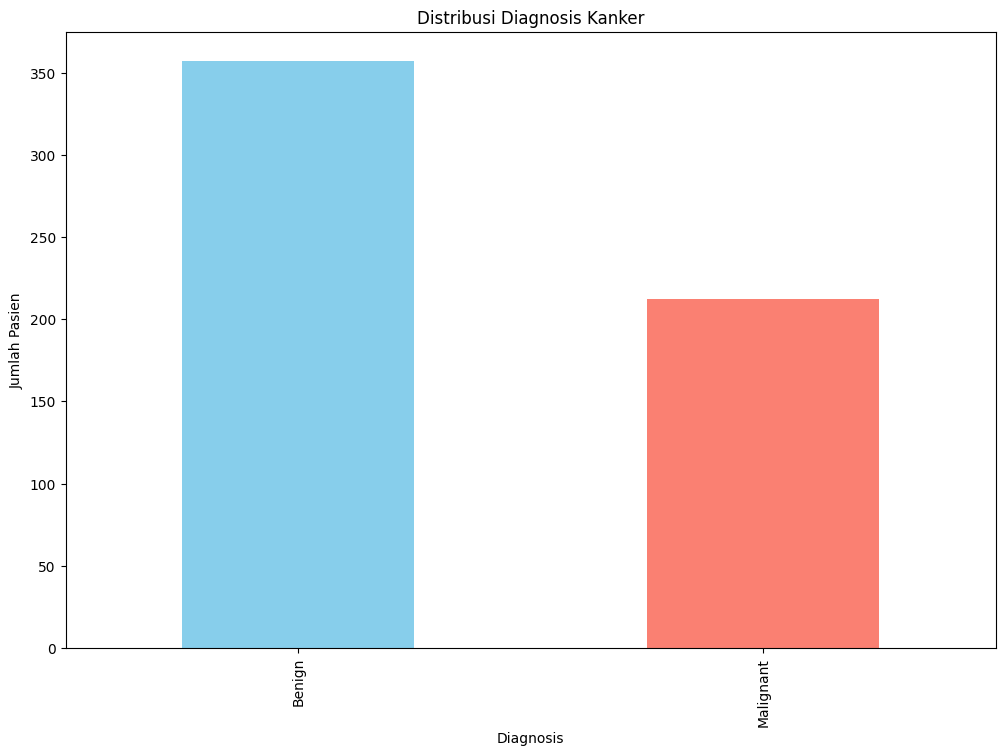

In [ ]:
# Konversi DataFrame PySpark ke Pandas DataFrame untuk visualisasi
pandas_df = df.toPandas()

plt.figure(figsize=(12, 8))
pandas_df['diagnosis_kanker'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.title('Distribusi Diagnosis Kanker')
plt.xlabel('Diagnosis')
plt.ylabel('Jumlah Pasien')
plt.show()

# Penjelasan: Grafik batang menunjukkan jumlah pasien dengan diagnosis kanker B (0) dan M (1).  Hal ini membantu melihat proporsi masing-masing kategori dalam dataset.

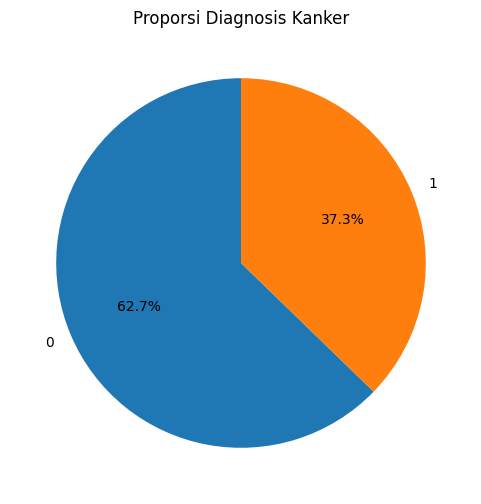

In [ ]:
plt.figure(figsize=(6, 6))
pandas_df['diagnosis_kanker'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Proporsi Diagnosis Kanker')
plt.ylabel('') # Hapus label y
plt.show()

# Penjelasan: Pie chart menampilkan proporsi relatif pasien dengan diagnosis kanker jinak dan ganas, memberikan gambaran visual yang mudah dipahami tentang sebaran kelas target.


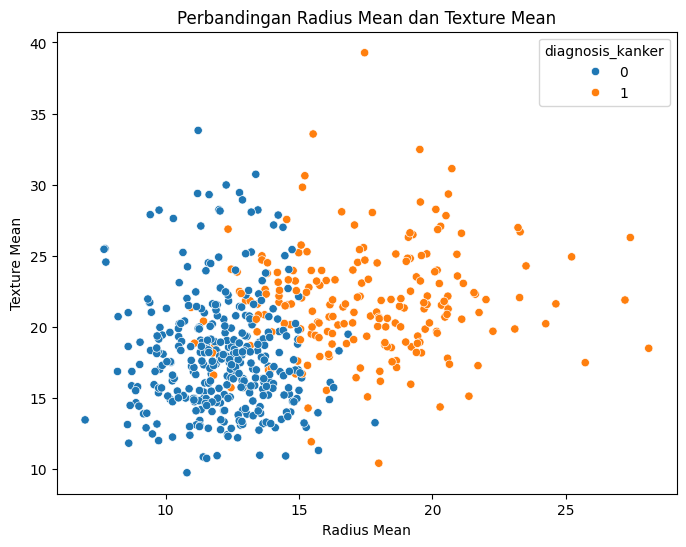

In [ ]:
#scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='radius_mean', y='texture_mean', hue='diagnosis_kanker', data=pandas_df)
plt.title('Perbandingan Radius Mean dan Texture Mean')
plt.xlabel('Radius Mean')
plt.ylabel('Texture Mean')
plt.show()



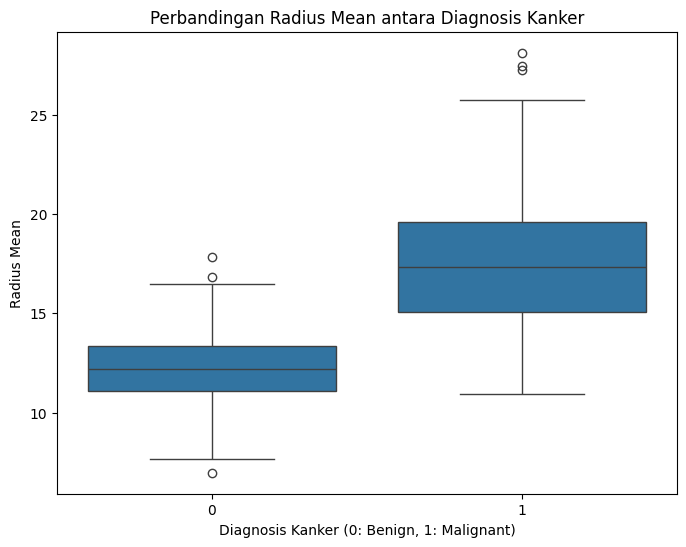

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='diagnosis_kanker', y='radius_mean', data=pandas_df)
plt.title('Perbandingan Radius Mean antara Diagnosis Kanker')
plt.xlabel('Diagnosis Kanker (0: Benign, 1: Malignant)')
plt.ylabel('Radius Mean')
plt.show()

# Penjelasan: Box plot membandingkan distribusi 'radius_mean' untuk pasien dengan diagnosis kanker jinak dan ganas.  Grafik ini menunjukkan median, kuartil, dan outlier untuk masing-masing grup, sehingga memudahkan dalam melihat perbedaan karakteristik fisik tumor berdasarkan diagnosis.

### 2. Pengembangan model machine learning###

In [ ]:
# Preprocessing Data
df = df.withColumnRenamed("diagnosis_kanker", "label")

In [ ]:
# Konversi DataFrame PySpark ke Pandas untuk SMOTE dan Outlier Handling
pandas_df = df.toPandas()
X = pandas_df.drop(columns=['label'])
y = pandas_df['label']

In [ ]:
# Mengatasi outlier menggunakan metode IQR
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
X = X.clip(lower=lower_bound, upper=upper_bound, axis=1)

In [ ]:
# Menerapkan SMOTE untuk menangani ketidakseimbangan kelas
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
# Menggabungkan kembali ke DataFrame
balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
balanced_df['label'] = y_resampled

In [ ]:
# Konversi kembali ke PySpark DataFrame
df = spark.createDataFrame(balanced_df)

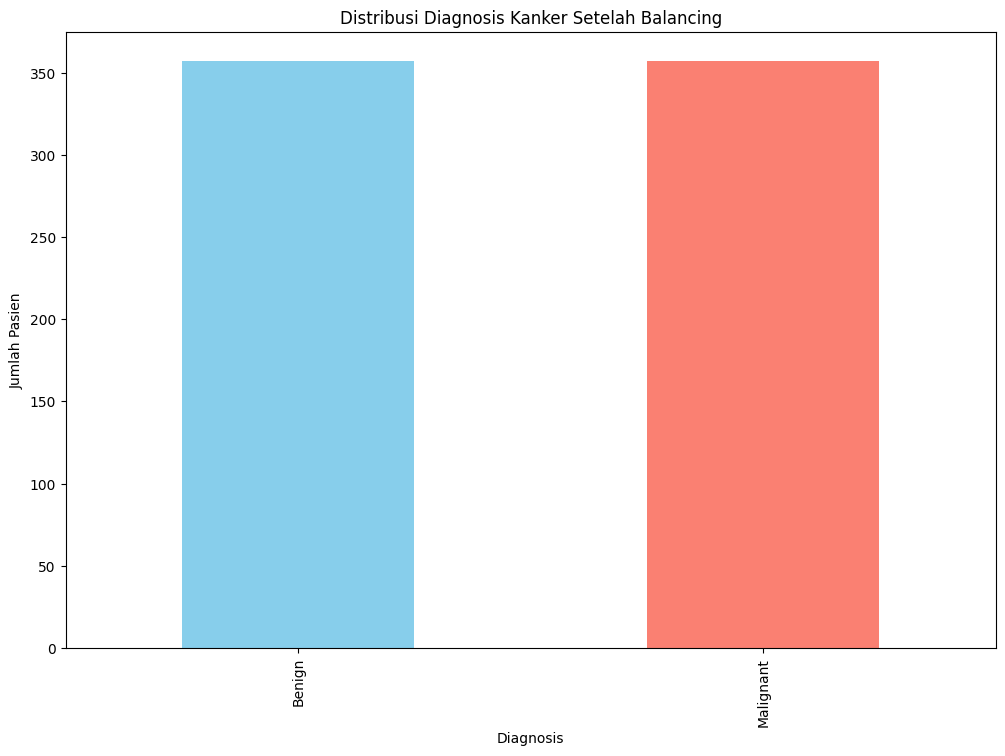

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 8))
balanced_df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.title('Distribusi Diagnosis Kanker Setelah Balancing')
plt.xlabel('Diagnosis')
plt.ylabel('Jumlah Pasien')
plt.show()

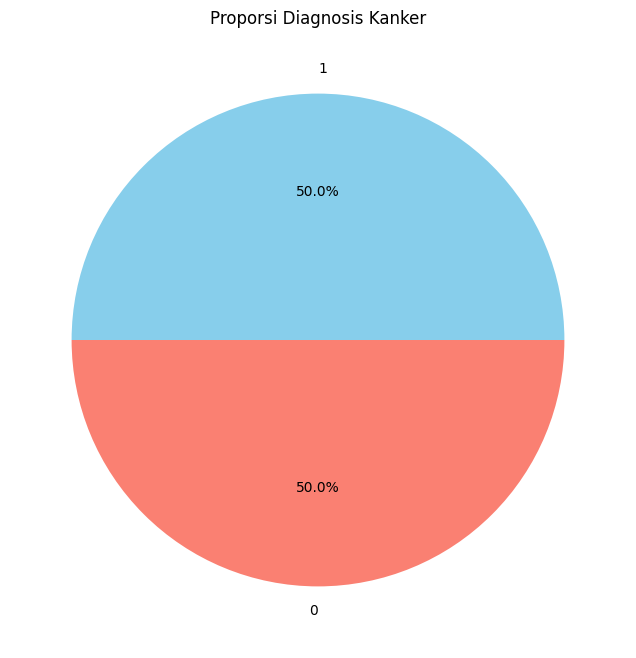

In [ ]:
# Pie Chart Distribusi Kelas
plt.figure(figsize=(8, 8))
balanced_df['label'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Proporsi Diagnosis Kanker')
plt.ylabel('')
plt.show()

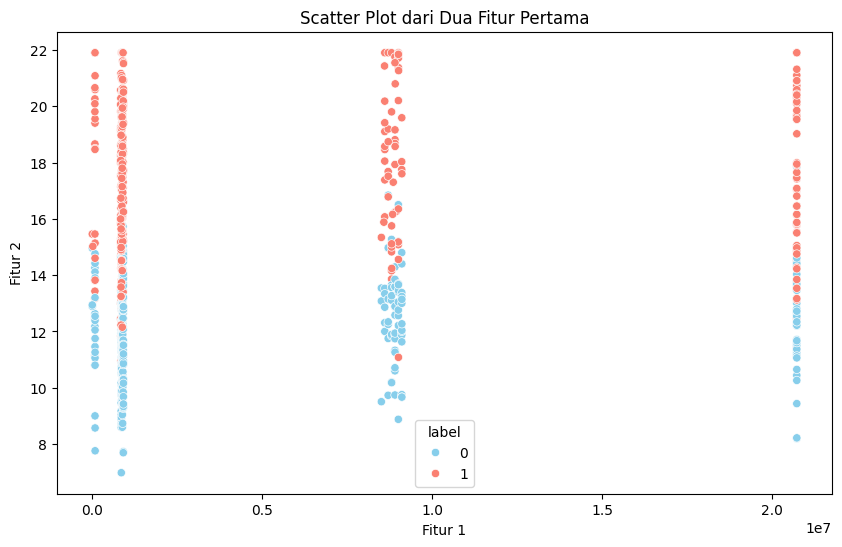

In [ ]:
# Scatter Plot untuk dua fitur pertama
plt.figure(figsize=(10, 6))
sns.scatterplot(x=balanced_df.iloc[:, 0], y=balanced_df.iloc[:, 1], hue=balanced_df['label'], palette=['skyblue', 'salmon'])
plt.title('Scatter Plot dari Dua Fitur Pertama')
plt.xlabel('Fitur 1')
plt.ylabel('Fitur 2')
plt.show()

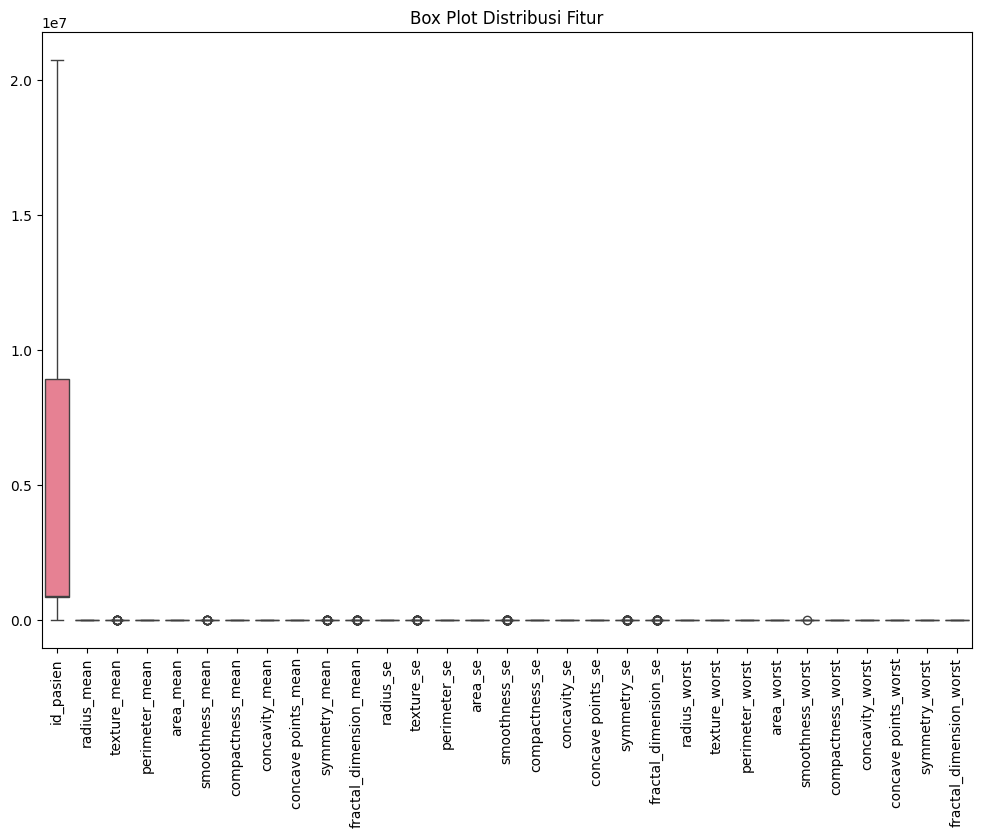

In [ ]:
# Box Plot untuk melihat distribusi fitur utama
plt.figure(figsize=(12, 8))
sns.boxplot(data=balanced_df.iloc[:, :-1])
plt.xticks(rotation=90)
plt.title('Box Plot Distribusi Fitur')
plt.show()

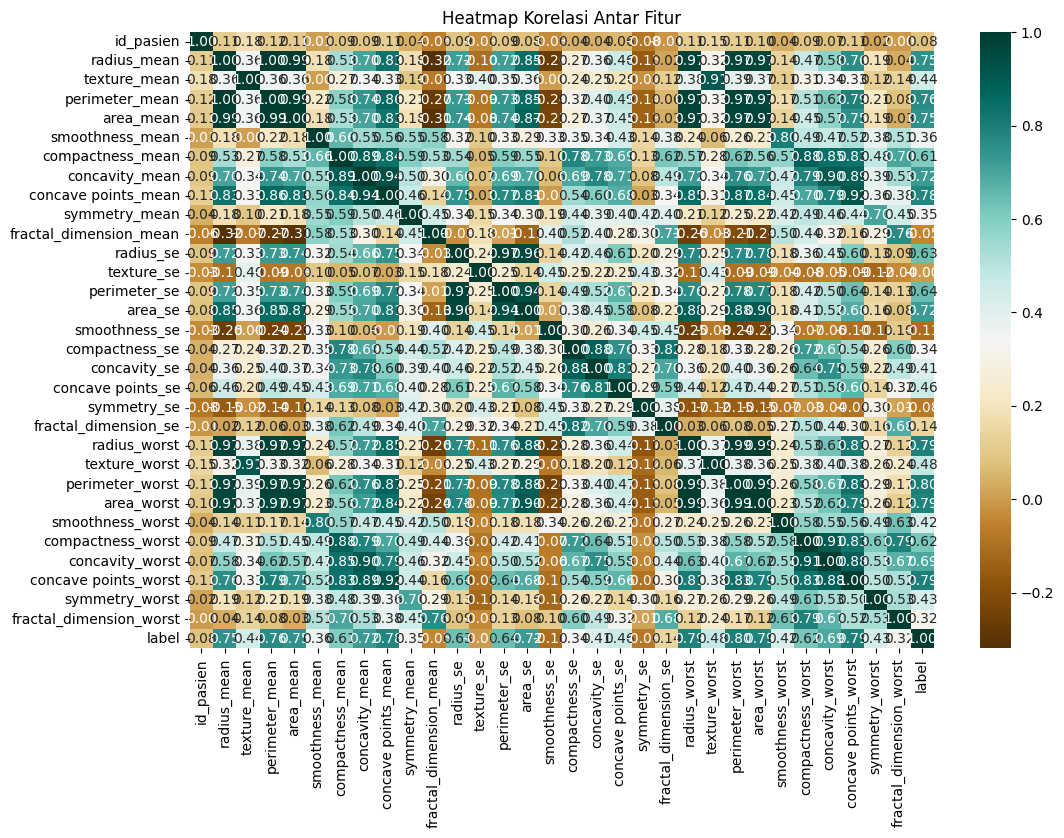

In [ ]:
# Heatmap Korelasi
plt.figure(figsize=(12, 8))
sns.heatmap(balanced_df.corr(), cmap="BrBG", annot=True, fmt=".2f")
plt.title("Heatmap Korelasi Antar Fitur")
plt.show()


In [ ]:
 # Memastikan distribusi nilai diagnosis_kanker
df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  357|
|    1|  357|
+-----+-----+



In [ ]:
# Pilih kolom numerik dan target
feature_columns = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean",
    "fractal_dimension_mean", "radius_se", "texture_se", "perimeter_se", "area_se"
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


# Membagi data menjadi data latih (training) dan data uji (test)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


# Fungsi untuk mengevaluasi model
def evaluate_model(model, train_data, test_data, model_name="Model"):
    # Membuat pipeline dengan assembler dan model
    pipeline = Pipeline(stages=[assembler, model])
    model_trained = pipeline.fit(train_data)
    predictions = model_trained.transform(test_data)

    # Evaluasi menggunakan kolom 'probability' untuk menghitung AUC
    evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability")
    auc = evaluator.evaluate(predictions)

    # Menampilkan classification report
    predictions_pd = predictions.select('label', 'prediction').toPandas()
    print(f"{model_name} Classification Report:")
    print(classification_report(predictions_pd['label'], predictions_pd['prediction']))

    # Membuat ROC Curve
    fpr, tpr, _ = roc_curve(predictions_pd['label'], predictions_pd['prediction'])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'{model_name} ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    return auc

**Random Forest**

Evaluating Random Forest Classifier
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        59
           1       0.94      0.93      0.93        67

    accuracy                           0.93       126
   macro avg       0.93      0.93      0.93       126
weighted avg       0.93      0.93      0.93       126



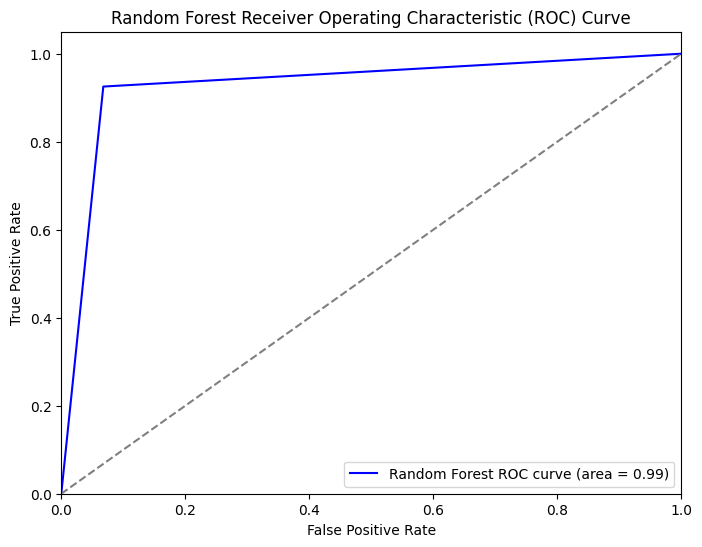

AUC: 0.9870984062737161
Random Forest AUC: 0.987


In [ ]:

# Random Forest Classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=200)
print("Evaluating Random Forest Classifier")
rf_auc = evaluate_model(rf_classifier, train_data, test_data, model_name="Random Forest")
print(f"AUC: {rf_auc:}")
print(f"Random Forest AUC: {rf_auc:.3f}")






**Gradient Boosted Trees**

Evaluating Gradient Boosted Trees Classifier
Gradient Boosted Trees Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        59
           1       0.90      0.97      0.94        67

    accuracy                           0.93       126
   macro avg       0.93      0.93      0.93       126
weighted avg       0.93      0.93      0.93       126



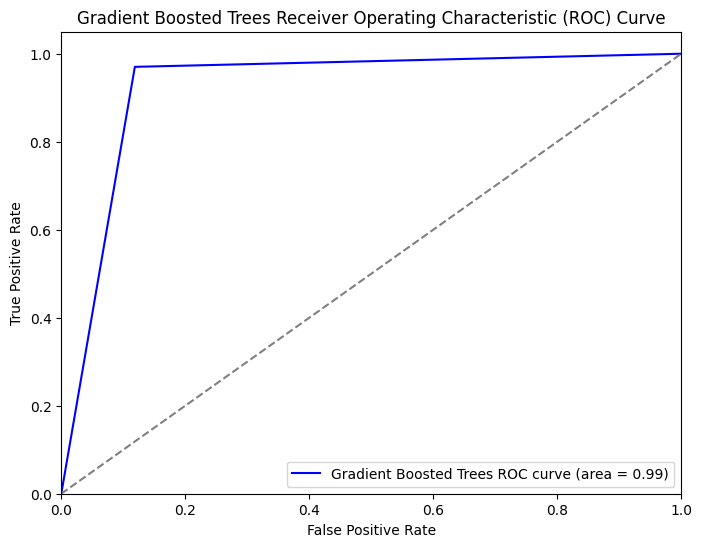

AUC: 0.9898811029597774
Gradient Boosted Trees AUC: 0.990


In [ ]:
# Gradient Boosted Trees Classifier
gbt_classifier = GBTClassifier(featuresCol="features", labelCol="label")
print("Evaluating Gradient Boosted Trees Classifier")
gbt_auc = evaluate_model(gbt_classifier, train_data, test_data, model_name="Gradient Boosted Trees")
print(f"AUC: {gbt_auc:}")
print(f"Gradient Boosted Trees AUC: {gbt_auc:.3f}")

**Naive Bayes**

Evaluating Naive Bayes Classifier
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        59
           1       0.89      0.76      0.82        67

    accuracy                           0.83       126
   macro avg       0.83      0.83      0.83       126
weighted avg       0.84      0.83      0.83       126



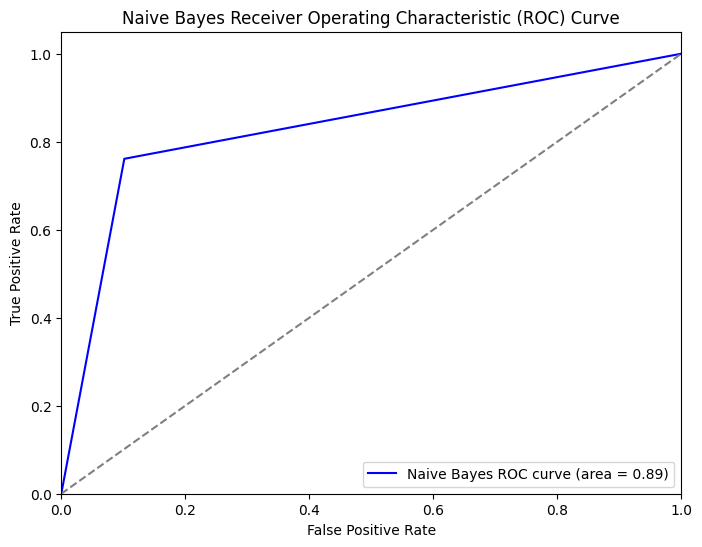

AUC: 0.8924867189476346
Naive Bayes AUC: 0.892


In [ ]:
# Naive Bayes Classifier

nb_classifier = NaiveBayes(featuresCol="features", labelCol="label")
print("Evaluating Naive Bayes Classifier")
nb_auc = evaluate_model(nb_classifier, train_data, test_data, model_name="Naive Bayes")
print(f"AUC: {nb_auc:}")
print(f"Naive Bayes AUC: {nb_auc:.3f}")



**Decision Tree Classifier**

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        59
           1       0.90      0.97      0.94        67

    accuracy                           0.93       126
   macro avg       0.93      0.93      0.93       126
weighted avg       0.93      0.93      0.93       126



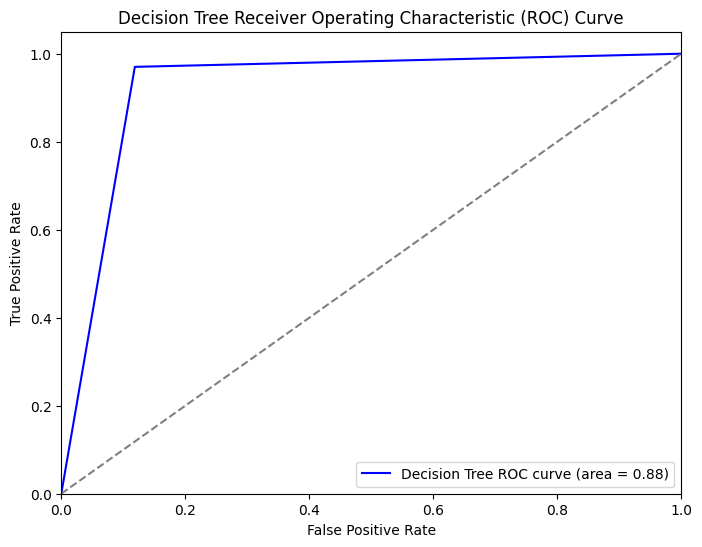

AUC: 0.8797116114343537
Decision Tree AUC: 0.880


In [ ]:
# Decision Tree Classifier

dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=5)
dt_auc = evaluate_model(dt_classifier, train_data, test_data, model_name="Decision Tree")
print(f"AUC: {dt_auc:}")
print(f"Decision Tree AUC: {dt_auc:.3f}")

##Hypertunning##

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")

Best Random Forest AUC: 0.9920313685808246


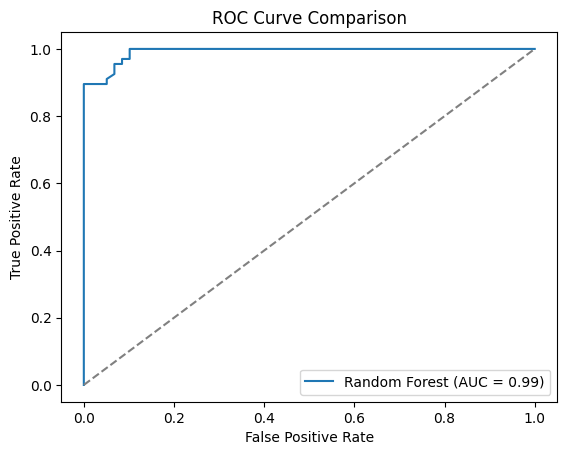

In [ ]:
# RANDOM FOREST HYPERTUNING
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
rf_paramGrid = (ParamGridBuilder()
                .addGrid(rf.numTrees, [50, 100, 200])
                .addGrid(rf.maxDepth, [5, 10, 15])
                .build())

rf_pipeline = Pipeline(stages=[assembler, rf])
rf_cv = CrossValidator(estimator=rf_pipeline,
                       estimatorParamMaps=rf_paramGrid,
                       evaluator=evaluator,
                       numFolds=5)

rf_model = rf_cv.fit(train_data)
rf_best_model = rf_model.bestModel
rf_predictions = rf_best_model.transform(test_data)
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Best Random Forest AUC: {rf_auc}")

# Plot ROC Random Forest
rf_pd = rf_predictions.select('label', 'probability').toPandas()
fpr_rf, tpr_rf, _ = roc_curve(rf_pd['label'], rf_pd['probability'].apply(lambda x: x[1]))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(rf_auc))

# ROC Plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

Best Gradient Boosted Trees AUC: 0.9908929926637997


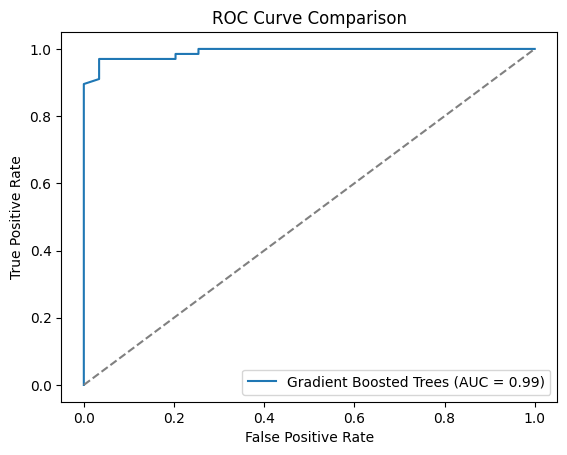

In [ ]:
# GRADIENT BOOSTED TREES HYPERTUNING
gbt = GBTClassifier(featuresCol="features", labelCol="label")
gbt_paramGrid = (ParamGridBuilder()
                 .addGrid(gbt.maxDepth, [5, 10])
                 .addGrid(gbt.maxIter, [10, 50])
                 .build())

gbt_pipeline = Pipeline(stages=[assembler, gbt])
gbt_cv = CrossValidator(estimator=gbt_pipeline,
                        estimatorParamMaps=gbt_paramGrid,
                        evaluator=evaluator,
                        numFolds=5,
                        parallelism=4)

gbt_model = gbt_cv.fit(train_data)
gbt_best_model = gbt_model.bestModel
gbt_predictions = gbt_best_model.transform(test_data)
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Best Gradient Boosted Trees AUC: {gbt_auc}")

# Plot ROC GBT
gbt_pd = gbt_predictions.select('label', 'probability').toPandas()
fpr_gbt, tpr_gbt, _ = roc_curve(gbt_pd['label'], gbt_pd['probability'].apply(lambda x: x[1]))
plt.plot(fpr_gbt, tpr_gbt, label='Gradient Boosted Trees (AUC = {:.2f})'.format(gbt_auc))

# ROC Plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [ ]:
# MODEL TERBAIK
best_model = max([(rf_auc, 'Random Forest'), (gbt_auc, 'Gradient Boosted Trees'), (nb_auc, 'Naive Bayes')], key=lambda x: x[0])
print(f"Model terbaik adalah {best_model[1]} dengan AUC: {best_model[0]:.2f}")

Model terbaik adalah Random Forest dengan AUC: 0.99
